In [1]:
import numpy as np
import pandas as pd 
import scienceplots
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from utils import generate_siso_data
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scienceplots
plt.style.use('science')

plt.style.use('science')
np.random.seed(12)

In [2]:
def generate_siso_data(n, test_size=0.2, noise_level=0.05, a1=0.5, a2=-0.3, b1=0.7):
    """
    Generates synthetic Single Input Single Output (SISO) data for an ARX model with na=2 and nb=2.
    :param n: Number of data points to generate.
    :param test_size: Proportion of the dataset to include in the test split.
    :param noise_level: Standard deviation of the noise.
    :param a1, a2: Coefficients for the autoregressive part of the model.
    :param b1, b2: Coefficients for the exogenous input part of the model.
    :return: Tuple of (y_train, x_train, y_test, x_test), where y is the target series and x is the exogenous series.
    """
    # Generating exogenous input (x) as a random signal
    u = np.random.randint(0, 10, size=n)

    # Generating the target series (y)
    y = np.zeros(n)
    for t in range(2, n):
        y[t] = a1 * y[t-1] + a2 * y[t-2] +  b1 * u[t-1]

    # Splitting the data into training and testing sets
    y_train, y_test, u_train, u_test = train_test_split(y, u, test_size=test_size, shuffle=False)

    return y_train, u_train, y_test, u_test

In [3]:
y_train, u_train, y_test, u_test = generate_siso_data(n=1000, noise_level=0.05)

y_train, u_train = y_train.reshape(-1,1), u_train.reshape(-1,1)
y_test, u_test = y_test.reshape(-1,1), u_test.reshape(-1,1)


In [4]:
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial

basis_function = Polynomial(degree=1)

arx_model = FROLS(
    order_selection=False,
    n_terms=4,
    extended_least_squares=False,
    ylag=2,
    xlag=1,
    estimator="least_squares",
    basis_function=basis_function,
)

arx_model.fit(X=u_train, y=y_train)

/home/alqua/anaconda3/envs/pytorch_env/lib/python3.11/site-packages/sysidentpy/utils/deprecation.py:37: FutureWarning: Passing a string to define the estimator will rise an error in v0.4.0. 
 You'll have to use FROLS(estimator=LeastSquares()) instead. 
 The only change is that you'll have to define the estimator first instead of passing a string like 'least_squares'. 
 This change will make easier to implement new estimators and it'll improve code readability.
  warnings.warn(message, FutureWarning)


In [5]:
from sysidentpy.utils.display_results import results


r = pd.DataFrame(
    results(
        arx_model.final_model,
        arx_model.theta,
        arx_model.err,
        arx_model.n_terms,
        err_precision=8,
        dtype="sci",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)
print(r)

  Regressors   Parameters             ERR
0    x1(k-1)   7.0000E-01  9.32216861E-01
1     y(k-1)   5.0000E-01  4.39672675E-02
2     y(k-2)  -3.0000E-01  2.38158713E-02
3          1   1.3048E-16  1.30968397E-34



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



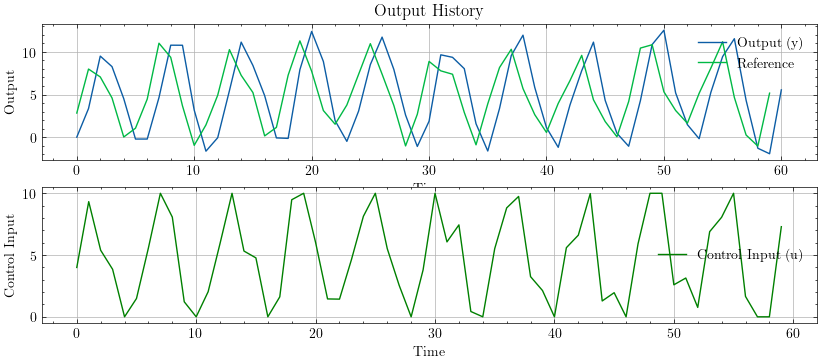

In [6]:
import casadi as ca 


a1, a2, b1 = 0.5, -0.3, 0.7

Q, R, Qi, ref = 1.9,0.01,0.6, 6.58
# MPC parameters
horizon = 60  # Prediction horizon

# Initialize system state, last control input, and integral of error
y_current = 0
u_last = 0
integral_error = 0

# Store history of control inputs and system states
u_history = []
y_history = [y_current]
error_history = []

sim_time = 60

lower_bound = 0
upper_bound = 10

time = np.linspace(0, 20 * np.pi, sim_time)
ref_arr = (upper_bound - lower_bound) / 2 * np.sin(time) + (upper_bound + lower_bound) / 2 + np.random.normal(0,1,sim_time)

for t in range(sim_time):
    # Define variables for MPC
    U = ca.SX.sym('U', horizon)
    Y = ca.SX.sym('Y', horizon)
    E = ca.SX.sym('E', horizon)
    ref = ref_arr[t]
    # Cost function and constraints
    cost = 0
    for k in range(horizon):
        y_prev1 = 0 if k == 0 else Y[k-1]
        y_prev2 = 0 if k <= 1 else Y[k-2]
        u_prev = u_last if k == 0 else U[k-1]
        Y[k] = a1 * y_prev1 + a2 * y_prev2 + b1 * u_prev

        cost += Q * (Y[k] - ref)**2 + R * U[k]**2


    # Optimization problem
    opts = {
        'ipopt.print_level': 0, 
        'print_time': 0,
        'ipopt.tol': 1e-8,           
        'ipopt.acceptable_tol': 1e-8
    }

    nlp = {'x': ca.vertcat(U), 'f': cost}
    solver = ca.nlpsol('solver', 'ipopt', nlp, opts)

    # Initial guess and bounds for control inputs
    lbx = 0 * np.ones(horizon)
    ubx = 10 * np.ones(horizon)

    # Solve MPC problem
    sol = solver(x0=0, lbx=lbx, ubx=ubx)
    u_optimized = sol['x'].full().flatten()

    # Apply the first control input to the system
    u_current = u_optimized[0]
    u_history.append(u_current)

    # Update the system state, last control input, and integral of error
    y_current = a1 * y_history[-1] + a2 * (y_history[-2] if len(y_history) > 1 else 0) + b1 * u_current*1.2
    y_history.append(y_current)
    u_last = u_current

# Plotting the results

plt.figure(figsize=(10, 6))

# Plotting the output history
plt.subplot(3, 1, 1)  # First subplot in a 3 row layout
plt.plot(y_history, label='Output (y)')
plt.plot(ref_arr, label='Reference')
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('Output History')
plt.legend()
plt.grid(True)

# Plotting the control input history
plt.subplot(3, 1, 2)  # Second subplot in a 3 row layout
plt.plot(u_history, label='Control Input (u)', color='g')
plt.xlabel('Time')
plt.ylabel('Control Input')
plt.legend()
plt.grid(True)

In [7]:
import random

def generate_random_reference(initial_ref, n):
    ref = initial_ref
    ref_history = []
    for k in range(0,n):
        if k % 15 == 0:
            ref = random.randint(1, 9) 
        ref_history.append(ref)
    return ref_history


ref_hist =  generate_random_reference(4, sim_time)

In [8]:
ref_hist =  generate_random_reference(1, sim_time)

In [9]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, FloatSlider

# ARX model parameters
a1, a2, b1 = 0.5, -0.3, 0.7

def run_mpc_simulation(Q, R, Qi):
    # MPC parameters
    horizon = 60  # Prediction horizon

    # Initialize system state, last control input, and integral of error
    y_current = 0
    u_last = 0
    integral_error = 0

    # Store history of control inputs and system states
    u_history = []
    y_history = [y_current]
    error_history = []

    sim_time = 60
    
    for t in range(sim_time):
        # Define variables for MPC
        U = ca.SX.sym('U', horizon)
        Y = ca.SX.sym('Y', horizon)
        E = ca.SX.sym('E', horizon)
        ref = ref_hist[t]
        
        # Cost function and constraints
        cost = 0
        error_history = []
        integral_error_step = 0
        for k in range(horizon):
            y_prev1 = 0 if k == 0 else Y[k-1]
            y_prev2 = 0 if k <= 1 else Y[k-2]
            u_prev = u_last if k == 0 else U[k-1]
            Y[k] = a1 * y_prev1 + a2 * y_prev2 + b1 * u_prev

            integral_error_step += Y[k] - ref
            E[k] = integral_error_step

            cost += Q * (Y[k] - ref)**2 + R * U[k]**2


        # Optimization problem
        opts = {
            'ipopt.print_level': 0, 
            'print_time': 0,
            'ipopt.tol': 1e-8,           
            'ipopt.acceptable_tol': 1e-8
        }

        nlp = {'x': ca.vertcat(U), 'f': cost}
        solver = ca.nlpsol('solver', 'ipopt', nlp, opts)

        # Initial guess and bounds for control inputs
        lbx = 0 * np.ones(horizon)
        ubx = 10 * np.ones(horizon)

        # Solve MPC problem
        sol = solver(x0=0, lbx=lbx, ubx=ubx)
        u_optimized = sol['x'].full().flatten()

        # Apply the first control input to the system
        u_current = u_optimized[0]
        u_history.append(u_current)

        # Update the system state, last control input, and integral of error
        y_current = a1 * y_history[-1] + a2 * (y_history[-2] if len(y_history) > 1 else 0) + b1 * u_current*1.2
        y_history.append(y_current)
        u_last = u_current
        integral_error =0
        error_history.append(y_current)

    # Plotting the results

    plt.figure(figsize=(10, 6))

    # Plotting the output history
    plt.subplot(3, 1, 1)  # First subplot in a 3 row layout
    plt.plot(y_history, label='Output (y)')
    plt.plot(ref_hist, label='Reference', color="black")
    plt.xlabel('Time')
    plt.ylabel('Output')
    plt.title('Output History')
    plt.legend()
    plt.grid(True)

    # Plotting the control input history
    plt.subplot(3, 1, 2)  # Second subplot in a 3 row layout
    plt.plot(u_history, label='Control Input (u)', color='g')
    plt.xlabel('Time')
    plt.ylabel('Control Input')
    plt.legend()
    plt.grid(True)

    # Plotting the error history
    plt.subplot(3, 1, 3)  # Third subplot in a 3 row layout
    plt.plot(error_history, label='Error', color='b')
    plt.xlabel('Time')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)


# Create interactive sliders
interact(run_mpc_simulation,
         Q=FloatSlider(min=0, max=5, step=0.01, value=1.9),
         R=FloatSlider(min=0, max=5, step=0.01, value=0.01),
         Qi=FloatSlider(min=0, max=2, step=0.01, value=0))

interactive(children=(FloatSlider(value=1.9, description='Q', max=5.0, step=0.01), FloatSlider(value=0.01, des…

<function __main__.run_mpc_simulation(Q, R, Qi)>